<h2>CNN and RNN Implementation Using Keras</h2>

This file contains the implementation of a CNN with RNN layers for multiclass sentiment analysis. I will be using Bidirectional LSTM layers within the CNN in order to retain context and connections between words in a sentence. The CNN layers process and extract features from the data.

<h3>Data Preprocessing</h3>

First, the data must be processed. I will be combining all of the statements and their corresponding metadata into one column.

<h2>Model with 3 Labels</h2>

Let's try the model with only 3 labels.

<h3>Data Preprocessing</h3>

In [2]:
import pandas as pd
import numpy as np
import nltk
import re
from tqdm import tqdm
import os
from tensorflow import keras

numeric_labels = {'pants-fire':0, 'false':1, 'barely-true':2, 'half-true':3, 'mostly-true':4, 'true':5}
path = os.getcwd() + '/data'
headers = ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'affiliation', 'barely_true',
           'false', 'half_true', 'mostly_true', 'pants-fire', 'context']


# lowercase, remove punctuation, remove numbers
def clean_text(text):
    if not isinstance(text, str):
        return text
    clean_text = text.lower()
    clean_text = re.sub(r'[^\w\s]', '', clean_text)
    return clean_text

# convert text labels to numbers
def clean_labels(label):
    return numeric_labels[label]

def shrink_label(label):

    if label >= 4:
        return 2
    elif label >= 2 and label < 4:
        return 1
    else:
        return 0


train = pd.read_csv(path + '/train.tsv', sep='\t', header=None, names=headers)
valid = pd.read_csv(path + '/valid.tsv', sep='\t', header=None, names=headers)
test = pd.read_csv(path + '/test.tsv', sep='\t', header=None, names=headers)

train['statement'] = train['statement'].apply(clean_text)
valid['statement'] = valid['statement'].apply(clean_text)
test['statement'] = test['statement'].apply(clean_text)
train['label'] = train['label'].apply(clean_labels)
train['label'] = train['label'].apply(shrink_label)
valid['label'] = valid['label'].apply(clean_labels)
valid['label'] = valid['label'].apply(shrink_label)
test['label'] = test['label'].apply(clean_labels)
test['label'] = test['label'].apply(shrink_label)

tr_data = train[['label', 'statement']]
tr_data = tr_data.dropna()
train_statements = tr_data['statement']
train_labels = tr_data['label']

va_data = valid[['label', 'statement']]
va_data = va_data.dropna()
valid_statements = va_data['statement']
valid_labels = va_data['label']

te_data = test[['label', 'statement']]
te_data = te_data.dropna()
test_statements = te_data['statement']
test_labels = te_data['label']

2024-04-10 20:57:13.775226: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-10 20:57:13.887228: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 20:57:13.887311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 20:57:13.897169: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-10 20:57:13.940264: I tensorflow/core/platform/cpu_feature_guar

<h3>Tokenizing, Padding, Model Setup, and Training</h3>

In [3]:
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Bidirectional, LSTM
# combine the dataframes into a single dataframe
combined = pd.concat([train_statements, test_statements, valid_statements], ignore_index=True)

# create a set that holds all the unique words in combined data frame
results = set()
combined.str.split().apply(results.update)

# len of set is the number of unique words
num_unique_words = len(results)
print(num_unique_words)
# max length of statements
max_len = max(train_statements.str.len().max(), valid_statements.str.len().max(), test_statements.str.len().max())
print(max_len)

# create tokenizer and fit it to train data
tokenizer = keras.preprocessing.text.Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_statements)

# create padded matrices for training, validation, and testing sets
train_sequences = tokenizer.texts_to_sequences(train_statements)
train_padded = keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')

valid_sequences = tokenizer.texts_to_sequences(valid_statements)
valid_padded = keras.preprocessing.sequence.pad_sequences(valid_sequences, maxlen=max_len, padding='post', truncating='post')

test_sequences = tokenizer.texts_to_sequences(test_statements)
test_padded = keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

#Add a custom layer here for embedding (like chat GPT. see if that works)

shrink_model = keras.models.Sequential([
    keras.layers.Embedding(num_unique_words,128),
    Conv1D(filters=128, kernel_size=5, padding='causal', activation='relu'),
    MaxPooling1D(2),
    Bidirectional(LSTM(32, return_sequences=True, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=keras.regularizers.l2(0.001))),
    Bidirectional(LSTM(32, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=keras.regularizers.l2(0.001))),
    keras.layers.Dense(3, activation='softmax')
])

shrink_model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(), metrics=["accuracy"])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = shrink_model.fit(train_padded, train_labels, epochs=2, validation_data=(valid_padded, valid_labels), callbacks=[early_stop], batch_size=64)

14959
3073
Epoch 1/2
160/160 [==============================] - 530s 3s/step - loss: 1.2253 - accuracy: 0.3837 - val_loss: 1.0775 - val_accuracy: 0.4408
Epoch 2/2
160/160 [==============================] - 537s 3s/step - loss: 1.0035 - accuracy: 0.5123 - val_loss: 1.0910 - val_accuracy: 0.4283


In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

<h3>Graphs</h3>

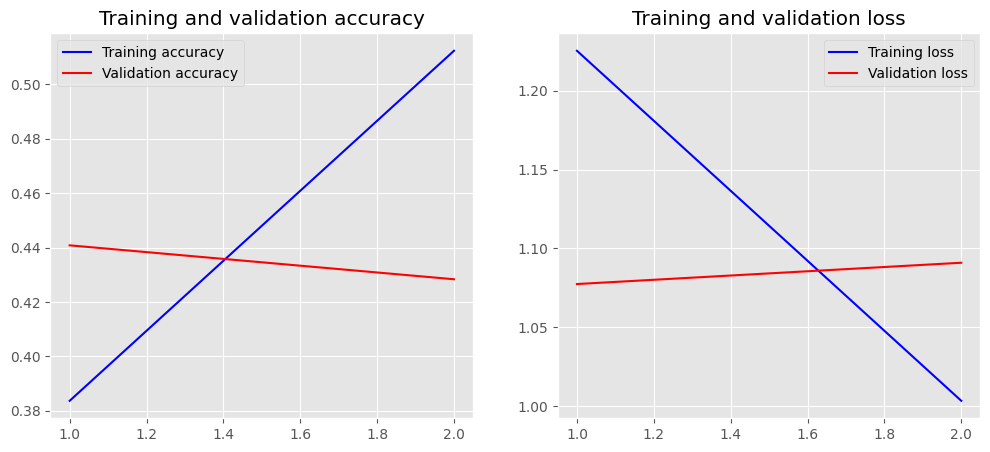

In [5]:
plot_history(history)

<h3>Testing</h3>

In [6]:
def weighted_ordinal_accuracy(y_true, y_pred, weight=0.5):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    abs_diff = np.abs(y_true - y_pred)
    mask = (abs_diff == 1) * weight
    weighted_diff = np.dot(abs_diff, mask)
    accuracy = 1 - (weighted_diff / len(y_true))
    
    return accuracy

In [7]:
score = shrink_model.evaluate(test_padded, test_labels, batch_size=64)

probs = shrink_model.predict(test_padded) 
pred = np.argmax(probs,axis=1)

ord_acc = weighted_ordinal_accuracy(test_labels, pred)

print("ordinal accuracy: ", ord_acc)

print("accuracy: ", score[1])

40/40 [==============================] - 27s 679ms/step
ordinal accuracy:  0.8014996053670087
accuracy:  0.4435674846172333


We get a 42.22% accuracy and a 75.57% ordinal accuracy for 3 labels!

Trying to export the model 

In [10]:
#keras.backend.clear_session()
shrink_model.save("web/news/views/shrink_model.h5")
tokenizer_json = tokenizer.to_json()
with open("web/news/views/tokenizer.json", "w") as json_file:
    json_file.write(tokenizer_json)
#shrink_model.save_weights("web/news/views/shrink_model.weights.h5")
# Immediate attempt 
#model = tf.keras.models.load_model("news/views/shrink_model.h5")

#new_shrink_model.load_weights("web/news/views/shrink_model.weights.h5")
new_model = keras.models.load_model("web/news/views/shrink_model.h5")
text_test = "For PFOA and PFOS, the enforceable maximum contaminant levels (MCLs) will be set at 4.0 parts per trillion individually."
text_test = clean_text([text_test])
test_sequences = tokenizer.texts_to_sequences(text_test)
#test_padded = keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')
test = keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')
new_model.predict(test)

/home/rbadal/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 771ms/step


array([[0.16606061, 0.4513386 , 0.38260084]], dtype=float32)

<h3>References</h3>

These are the sources I used when coding. I will look into more stuff as I continue to experiment with the CNN-RNN model.

Luay, M. (2023, September 22). *Sentiment analysis using recurrent neural network(rnn),long short term memory(lstm) and...* Medium. https://medium.com/@muhammadluay45/sentiment-analysis-using-recurrent-neural-network-rnn-long-short-term-memory-lstm-and-38d6e670173f 

Nasir, J. A., Khan, O. S., & Varlamis, I. (2021, January 5). *Fake news detection: A hybrid CNN-RNN based Deep Learning Approach*. International Journal of Information Management Data Insights. https://www.sciencedirect.com/science/article/pii/S2667096820300070#sec0012 